Hi Alice! It looks like last time I was confused on a few key points. I do think there might be some ways to make some of those intuitions relevant to the correct case, so this notebook is an attempt to clarify things and see what results we can bring in. 

# Setup and Notation

I'm going to try to follow the [Wikipedia](https://en.wikipedia.org/wiki/Wishart_distribution) notation fairly closely. 

Let $A$ be a positive-definite $p\times p$ matrix with law $\eta$. Let $\nu_k$ be a measure on the set $\{I \subset [p] : |I| = k\}$. Then, we define the $k$th logdet measure $\mu_{k,A}$  on $\mathbb{R}$ for matrix $A$ via the formula 

$$\mu_{k,A}(B) \triangleq \nu(\log |A_I| \in B)$$

When $A \sim \eta$ for some measure $\eta$ on $\mathbb{R}_{+}^{p\times p}$, $\mu_{k,A}$ is itself random. We define $\mu_{k,\eta}(B) \triangleq \eta(\mu_{k,A}(B))$. We are interested in the case that $\eta$ is Wishart with some parameters, and we'll just write $\mu_{k} = \mu_{k,\eta}$. 

We are interested in the behavior of quantities like: 

$$m_k = \mathbb{E}_{\mu_{k}}[Y] \quad \text{and} \quad v_k = \text{var}_{\mu_{k}}[Y]\;,$$

which are the expected mean and variance of $\mu_{k}$. 

## A Problem Reduction

The way to completely compute $\mu_{k}$ and its moments would involve pulling many samples $\{A^{(i)}\}$ from $\eta$ and then computing $A^{(i)}_J$ for each index set $J$ of size $k$. I'm first going to argue that, in the case of the Wishart Law, we can sample from matrices of size $k$ instead, which is a significant computational savings. 

**Claim:** Let $A \sim W_p(n,V)$. Then, for any fixed $I$, $A_I \sim W_{k}(n,V_I)$.

*Proof:* I expect the following is well-known. We can sample from $W_p(n,V)$ by letting $X \sim \mathcal{N}^n(0; V)$ for $V \in \mathbb{R}_+^{p \times p}$, and constructing $A = X^TX$, which will be distributed according to  $W_p(n,V)$. By construction, $A_I = X_{[I]}^T X_{[I]}$, where $X_{[I]}$ is the matrix obtained by keeping only the columns of $X$ listed in $I$. But $X_{[I]}$ is then a sample from $\mathcal{N}^n(0, V_I)$, so $A_I$ is in turn distributed according to $W_{k}(n,V_I)$. 

## Mean

**Corollary 1:** Let $m_I = \mathbb{E}_{\mu_k}[Y|I]$, which corresponds to the expectation over the Wishart ensemble while holding the index set fixed. Then,

$$m_I = \psi_k\left(\frac n 2\right) + k \, \log(2) + \log|V_I|$$

*Proof:* By [Wikipedia](https://en.wikipedia.org/wiki/Wishart_distribution#Log-expectation). 

**Remark:** What's helpful here is that, to compute $m_k = \mathbb{E}_{\nu}[m_I]$, it suffices to compute $\mathbb{E}_{\nu}[\log |V_I|]$, where $V$ is no longer random but is the fixed scale parameter of the ensemble. 

## Variance

Again from Wikipedia, the conditional variance is now

$$v_{I} \triangleq \text{var}(Y|I) = \sum_{i=1}^k \psi_1\left(\frac{n+1-i} 2\right)\;.$$

This quantity does not explicitly depend on $I$, only $k$. We'll therefore write it as $u_k$. Applying the law of total variance, we obtain 

$$
    \begin{aligned}  
      v_k &= \mathbb{E}_{\nu}[\text{var}(Y|I)] +  \text{var}_{\nu}[\mathbb{E}[Y|I]] \\ 
          &= u_k + \text{var}_\nu(m_I) \\ 
          &= u_k + \text{var}_\nu(\log |V_I|)\;.
    \end{aligned}
$$

Call this result **Corollary 2**. 

In summary, we started with the problem of computing the *expected* mean and variance of the $k$th logdet measure under the the Wishart distribution, and have reduced that problem to computing the mean and variance of the *empirical* logdet measure of the scale matrix. 

# Implementation

Let's go ahead and implement these formulae: 

In [1]:
import numpy as np
from scipy.stats import wishart
from matplotlib import pyplot as plt
from scipy.special import digamma, polygamma
%matplotlib inline

In [2]:
def sub(A, I):
    return A[I[:, np.newaxis], I]

def m_polygamma(order, j, x):
    # order 0 coincides with the multivariate digamma
    # order 1 is the multivariate trigamma
    # formulae from 
    # https://en.wikipedia.org/wiki/Multivariate_gamma_function
    ix = np.arange(1, j+1)
    return np.sum(polygamma(order, x + (1 - ix)/2))


def minor_expectation(V, n, I):
    # from corollary 1
    V_sub = sub(V, I) 
    k = len(I)
    return m_polygamma(0, k, n / 2.0) + k*np.log(2) + np.linalg.slogdet(V_sub)[1]

def minor_variance(V, k, n, j_samples):
    # from corollary 2, using a finite sample to estimate the second term. 
    def f():
        I = np.random.choice(p, k, replace = False)
        V_sub = sub(V, I) 
        return np.linalg.slogdet(V_sub)[1]
        
    var_term = np.var([f() for i in range(j_samples)])
    
    kay = np.arange(1, k + 1)
    poly_term = np.sum(polygamma(1, (n + 1 - kay)/2))
    return var_term + poly_term

# Experiments

The first thing we'll do is fix the parameters of a Wishart distribution, including the degrees of freedom $n$ and the scale matrix $V$. 

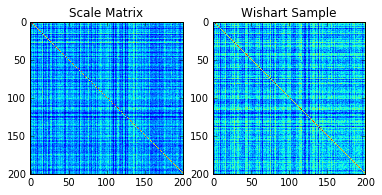

In [ ]:
# fixed scale matrix of size p

p = 200
n = 300

X = np.random.rand(n,p)
V = np.matmul(X.T,X)

# Here's a sample from the corresponding Wishart distribution
W = wishart.rvs(df=n, scale=V)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(V, interpolation = 'nearest')
ax2.imshow(W, interpolation = 'nearest')

ax1.set(title = 'Scale Matrix')
ax2.set(title = 'Wishart Sample')

## Data Generation

Let's generate some data, sampling from the full joint distribution of $I$ and $W$. This is "ground truth" for this problem: 

In [ ]:
def joint_sample(V, k, n, j_samples, moments = True):
    def f():
        W = wishart.rvs(df=n, scale=V)
        I = np.random.choice(p, k, replace = False)
        return np.linalg.slogdet(sub(W, I))[1]
    vec = [f() for j in range(j_samples)]
    if not moments:
        return vec
    else:
        return np.mean(vec), np.var(vec)

# generate 100 logminors of size k for each k from the 
# joint distribution of W and I, and compute the 
# mean and variance

j_samples = 100

kay = range(1, p+1)
data = [joint_sample(V, k, n, j_samples, moments = True) for k in kay]
m, v = zip(*data)

In [ ]:
fig = plt.figure(figsize = (10, 3))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(kay, m)
ax2.plot(kay, v)
ax3.plot(kay, np.sqrt(v)/m)

ax1.set(title = 'mean')
ax2.set(title = 'variance')
ax3.set(title = 'coefficient of variation')

# Validation of corollaries

Let's now check our corollaries by plotting the functions they give against the empirical moments: 

In [ ]:
# Validation of corollary (for mean)

fig = plt.figure(figsize = (7, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# mean
ex = [minor_expectation(V, n, np.random.choice(p, k, replace = False)) 
      for k in kay]
upper = np.max(ex[:-1])
ax1.plot([0, upper], [0, upper], color = 'black')
ax1.scatter(ex, m)
ax1.set(title = 'mean')


# variance 
ex = [minor_variance(V, k, n, j_samples) for k in kay]
upper = np.max(ex[:-1])
ax2.plot([0, upper], [0, upper], color = 'black')
ax2.scatter(ex, v)
ax2.set(title = 'variance')

Looks ok! The line of equality isn't even visible for the mean. The scatter around the variance due to finite sampling is more noticeable. 

# Implications?


I think what I've learned is this: 

   > In order to study the joint moments of the logminors, it suffices to study the the moments of $\nu_k$, the measure over the index set $I$ with respect to the fixed scale matrix $V$. The joint moments are related to these via simple analytic formulae, which could potentially give exact or analytic asymptotic results. 
   
Based on the results above, I think that further results here are going to depend on a measure over $V$ in order to compute things like $\mathbb{E}_\nu[\log |V_I|]$. Suggestions based on your application? Maybe it's governed by an underlying network?....

It feels like there might be some rich structure here...